In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from spacy_langdetect import LanguageDetector
from spacy.language import Language
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer
import spacy
from nltk.stem import *
from nltk.stem.porter import *
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score as f1
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding,LSTM,SpatialDropout1D
from keras.callbacks import EarlyStopping

In [2]:
# import dataset (apps and reviews)
apps = pd.read_csv('apps.csv')
reviews = pd.read_csv('reviews.csv') 
pd.set_option('display.max_columns', None)

In [3]:
# Extract date of each review and convert them into year and month
for i in range(len(reviews)):
    reviews.loc[i,'createYear']=reviews.loc[i,'at'][:4]
    reviews.loc[i,'createMonth']=reviews.loc[i,'at'][5:7]
    
# drop unnecessary variables
reviews=reviews.drop(columns=['reviewId', 'userImage','replyContent','repliedAt','sortOrder','at'])
apps=apps.drop(columns=['description', 'descriptionHTML', 'summary', 'summaryHTML',
       'installs', 'minInstalls','histogram','price', 'free', 'currency',
        'sale', 'saleTime', 'originalPrice', 'url',
       'saleText', 'offersIAP', 'inAppProductPrice', 'size', 'androidVersion',
       'androidVersionText', 'developer', 'developerId', 'developerEmail',
       'developerWebsite', 'developerAddress', 'privacyPolicy',
       'developerInternalID', 'genre', 'genreId', 'icon', 'headerImage',
       'screenshots', 'video', 'videoImage', 'contentRating',
       'contentRatingDescription', 'adSupported', 'containsAds', 'released',
       'updated', 'version', 'recentChanges', 'recentChangesHTML',
       'editorsChoice', 'similarApps', 'moreByDeveloper','ratings','reviews'])
apps=apps.rename(columns={'score':'appscore'})

# merge apps and reviews 
reviews=reviews.merge(apps, how='left', on='appId')
reviews=reviews.drop(columns=['appId'])

# drop null content reviews
reviews=reviews.dropna(subset=['content','thumbsUpCount']).reset_index(drop=True)

In [4]:
# classify thumbs up count for further analysis
for i in range(len(reviews)):
    if reviews.loc[i,'thumbsUpCount']<0:
        reviews.loc[i,'thumbsUpCount']=0
    elif reviews.loc[i,'thumbsUpCount']<10:
        reviews.loc[i,'thumbsUpCount']=1
    elif reviews.loc[i,'thumbsUpCount']<50:
        reviews.loc[i,'thumbsUpCount']=2
    elif reviews.loc[i,'thumbsUpCount']<100:
        reviews.loc[i,'thumbsUpCount']=3
    else:
        reviews.loc[i,'thumbsUpCount']=4

In [5]:
# set up language detector
def get_lang_detector(nlp,name):
    return LanguageDetector()

nlp=spacy.load('en_core_web_sm')
Language.factory("language_detector",func=get_lang_detector)
nlp.add_pipe('language_detector',last=True)

# remove non-English reviews
for i in range(len(reviews)):
    text=reviews.loc[i,'content']
    doc=nlp(text)
    detect_language=doc._.language
    if detect_language['language']!='en':
        reviews=reviews.drop([i])
reviews=reviews.reset_index(drop=True)

In [6]:
# save the processed data locally for further use
reviews.to_csv('reviews_processed1.csv', encoding='utf-8',index=False)

In [161]:
reviews=pd.read_csv('reviews_processed1.csv')

### Tokenize

In [162]:
# tokenize the review content into words
def tokenize(df):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    return tokenizer.tokenize(df['content'])

# remove noisy tokens
def remove_noise(df):
    mylist=["'t","'s","'ve","'m","'re",'.','..','...','....','.....','......', ').', '.,',
            'one',"'ll",'would','app','argos','tesco','amazon','ebay','shein','asos',
            'depop' ,'phone' ,'lidl','ms','morrisons','morrison'
           ]+list(string.ascii_lowercase)+[str(integer) for integer in range(101)]
    remove_these = set(stopwords.words('english') + list(string.punctuation) + list(string.digits)+mylist)
    filtered_text = [word 
                 for word in df['tokens'] 
                 if not word in remove_these]
    return filtered_text

# normalization
def normalise(df):
    porter = SnowballStemmer("english")
    return [porter.stem(t) for t in df['tokens']]

def lemm(df):
    WNlemma = nltk.WordNetLemmatizer()
    return [WNlemma.lemmatize(t) for t in df['tokens']]

# break reviews into sentece level
def sentence(df):
    sentences = sent_tokenize(df['content']) # split at sentence level
    return sentences

# classify the score
def classify(df):
    if df['score']>3:
        return 'pos'
    elif df['score']<3:
        return 'neg'
    elif df['score']==3:
        return 'neutral'

In [163]:
# preprocessing the reviews
reviews['content']=reviews['content'].str.lower()
reviews['tokens']=reviews.apply(lambda r:tokenize(r),axis=1)
reviews['tokens']=reviews.apply(lambda r:remove_noise(r),axis=1)
reviews['category']=reviews.apply(lambda r:classify(r),axis=1)
# reviews['tokens']=reviews.apply(lambda r:normalise(r),axis=1)
reviews['tokens']=reviews.apply(lambda r:lemm(r),axis=1)
reviews['sentences']=reviews.apply(lambda r:sentence(r),axis=1)
reviews=reviews.reset_index(drop=True)

In [164]:
# check the most common words
tokens=[]
for index,row in reviews.iterrows():
    tokens.extend(row['tokens'])

fdist_filtered = FreqDist(tokens)
# print( [word for (word,count) in fdist_filtered.most_common(300)])

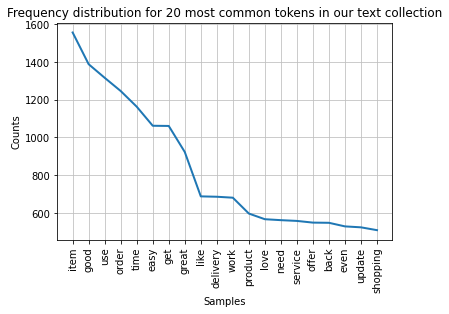

<AxesSubplot:title={'center':'Frequency distribution for 20 most common tokens in our text collection'}, xlabel='Samples', ylabel='Counts'>

In [165]:
fdist_filtered.plot(20,title='Frequency distribution for 20 most common tokens in our text collection')

In [92]:
# copy reviews for further uses
reviews_vader=reviews.copy()
reviews_lstm=reviews.copy()

### Naive Bayes and Random Forest

In [166]:
# shuffle df
reviews = shuffle(reviews)

In [167]:
# create features
def getWordVector(document, features):
    # only keep a set, the count of the words does not matter
    document_words = set(document)
    
    # create a new list to store the features
    doc_features = {}
    for word in features:
        # if the word is present, True is stored, otherwise, False is stored
        doc_features["contains_"+word] = (word in document_words)
    return doc_features

all_words = nltk.FreqDist(tokens)


features = {w for w in all_words.keys() if all_words[w]>50}

featureset = [(getWordVector(rev, features), cat) for (rev, cat) in zip(reviews['tokens'],reviews['category'])]

# len(features)  443

In [168]:
# Create binary vectors 
def getBinaryVector(review, features):
    # the output is a vector of 1's and 0's to indicate whether a word is present in the document
    x = []
    # count does not matter
    review = set(review)

    # go through the features (all words)
    for word in features:
       # check whether the word is present
        if word in review:
            x.append(1)
        else:
            x.append(0)   
    return x

In [169]:
X = []
y = []

for (rev, category) in zip(reviews['tokens'],reviews['category']):
    # convert your review into a vector and save it into the feature matrix
    X.append(getBinaryVector(rev, features))
    
    # save the label for your dependent variable list
    y.append(category)

X_df = pd.DataFrame(data = X, columns = features)
    
# train and test split with sklearn
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2,random_state=42)

In [17]:
# implement three models
nb = GaussianNB()
rf = RandomForestClassifier()
clf=MultinomialNB(alpha=0.01)

nb_fit = nb.fit(X_train, y_train)
rf_fit = rf.fit(X_train, y_train)
clf_fit=clf.fit(X_train, y_train)

# predict based on the test data points
y_pred_nb = nb_fit.predict(X_test)
y_pred_rf = rf_fit.predict(X_test)
y_pred_clf=clf_fit.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_nb)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_clf=accuracy_score(y_test, y_pred_clf)
print("Accuracy naive Bayes is :"+str(accuracy))
print("Accuracy random forest is :"+str(accuracy_rf))
print("Accuracy multinomial NB is :"+str(accuracy_clf))

Accuracy naive Bayes is :0.5906927551560022
Accuracy random forest is :0.6726599682707562
Accuracy multinomial NB is :0.70386039132734


In [20]:
# get evaluation metrics for multi classes classification
def evaluation_metrics(y_test,prediction):
    a=accuracy_score(y_test,prediction) # accuracy
    b=recall(y_test,prediction,average='micro')
    c=precision(y_test,prediction,average='macro')
    d=f1(y_test,prediction,average='weighted')
    return {'Accuracy':a,'Recall':b,'Precision':c,'F1':d}

In [21]:
# Multinomial GB
evaluation_metrics(y_test,y_pred_clf)

{'Accuracy': 0.70386039132734,
 'Recall': 0.70386039132734,
 'Precision': 0.6307729403584326,
 'F1': 0.6852484178805656}

In [22]:
# Random forest
evaluation_metrics(y_test,y_pred_rf)

{'Accuracy': 0.6726599682707562,
 'Recall': 0.6726599682707562,
 'Precision': 0.5522654557879606,
 'F1': 0.6395349361730804}

In [23]:
# random forest - get important features
rf_important_features=[]
for feature, importance in zip(X_df.columns, sorted(rf.feature_importances_)):
    if importance > 0.005:
#         print(feature, ' score: \t', round(importance, 3))
        rf_important_features.append(feature)

#### Prediction

<AxesSubplot:xlabel='prediction'>

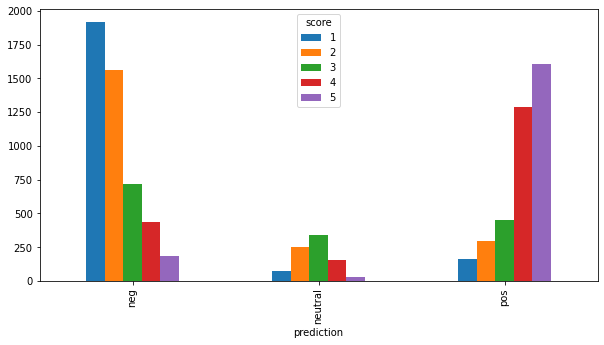

In [28]:
pd.crosstab(reviews['prediction'],reviews['score']).plot.bar(figsize=(10,5))

<AxesSubplot:xlabel='prediction'>

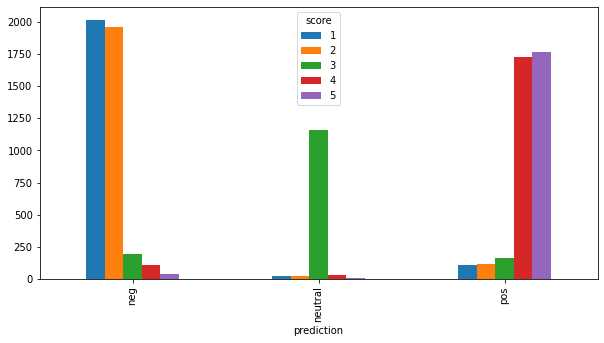

In [29]:
reviews_rf=reviews.copy()
reviews_rf['prediction']=rf_fit.predict(X_df)
pd.crosstab(reviews_rf['prediction'],reviews['score']).plot.bar(figsize=(10,5))

<AxesSubplot:xlabel='prediction'>

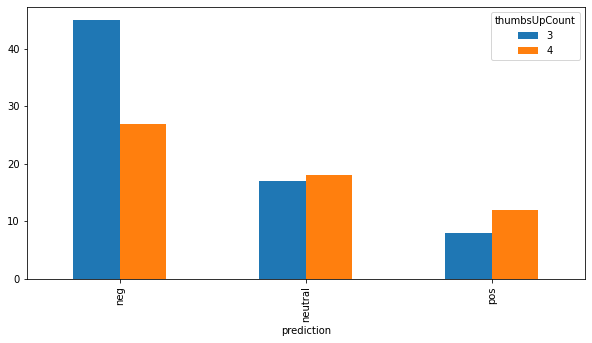

In [30]:
# reviews.groupby(['prediction','thumbsUpCount'])['content'].count()
reviews_thumbs=reviews[reviews['thumbsUpCount']>2]
pd.crosstab(reviews_thumbs['prediction'],reviews_thumbs['thumbsUpCount']).plot.bar(figsize=(10,5))

<AxesSubplot:ylabel='content'>

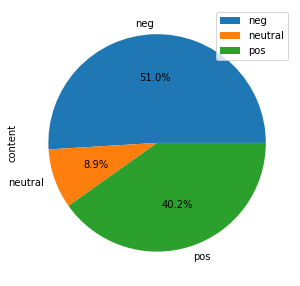

In [31]:
reviews.groupby(['prediction']).count().plot(kind='pie',y='content',figsize=(5,5),autopct='%1.1f%%')

In [32]:
def predict_output(df,predict_v,polarity,model):
    pred_output = X_test.copy()
    predc = pd.merge(pred_output, df[[predict_v]],left_index=True,right_index=True)
    predc["prediction"] = model
    predc = predc[predc['prediction']==polarity]
    app = predc[predict_v].value_counts()[0:10]
    app.plot(kind = 'bar')
    # plt.gca().invert_xaxis()

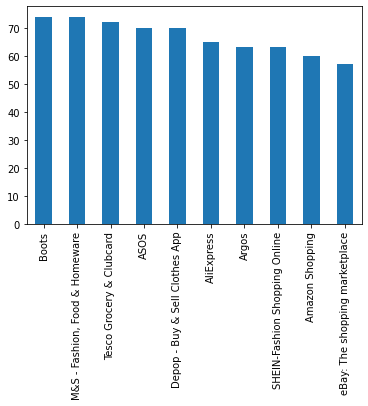

In [125]:
predict_output(reviews,'title','pos',y_pred_clf) #NB pos

In [186]:
pos_apps=[ 'Boots','M&S - Fashion, Food & Homeware', 'Tesco Grocery & Clubcard','ASOS','Depop - Buy & Sell Clothes App','AliExpress','Argos']
shein=['SHEIN-Fashion Shopping Online']

In [214]:
pos_reviews=reviews[reviews['title'].isin(pos_apps)]
shein_reviews=reviews[reviews['title'].isin(shein)]

In [219]:
def get_specific_apps(apps):
    pos_reviews = X_test.copy()
    pos_reviews = pd.merge(pos_reviews, reviews[['title']],left_index=True,right_index=True)
    pos_reviews['prediction']=y_pred_clf
    # pos_reviews = pos_reviews[pos_reviews['prediction']=='positive']
    # extract positive apps
    pos_reviews=pos_reviews[pos_reviews['title'].isin(apps)]
    
    from sklearn.inspection import permutation_importance
    # Multinomial GB - get important features 
    # positive apps
    imps = permutation_importance(clf, pos_reviews.drop(columns=['title','prediction']), pos_reviews['prediction'])
    importances = imps.importances_mean
    std = imps.importances_std
    indices = np.argsort(importances)[::-1]

    clf_important_features={}

    # Print the feature ranking
    
#     temp=pd.merge(X_df, reviews[['title']],left_index=True,right_index=True)
#     temp=temp[temp['title'].isin(apps)]
#     temp=temp.drop(columns=['title'])
    
    for f in range(pos_reviews.shape[1]):
        if importances[indices[f]]<0.001:
            break
        else:
            clf_important_features[X_df.columns[indices[f]]]=1
#             clf_important_features[temp.columns[indices[f]],importances[indices[f]]]
    
    return clf_important_features
    #         print("%d. %s (%f)" % (f + 1, X_df.columns[indices[f]], importances[indices[f]]))
    # clf_important_features

In [220]:
pos_features=get_specific_apps(pos_apps)

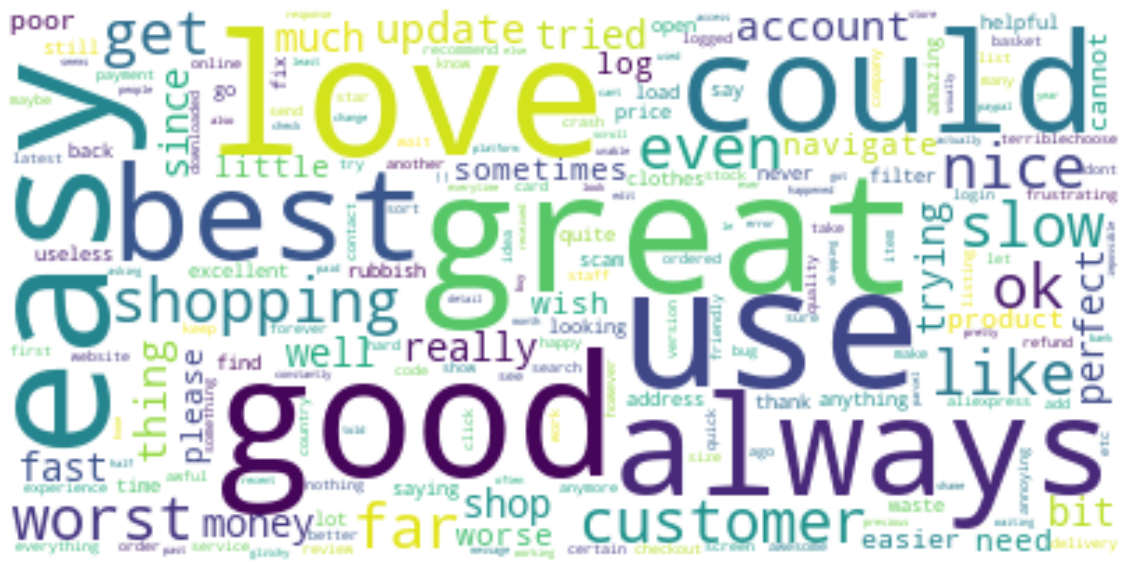

In [221]:
cloud = WordCloud(max_font_size=60,background_color='white', colormap = 'viridis').generate_from_frequencies(FreqDist(pos_features))
plt.figure(figsize=(20,20))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

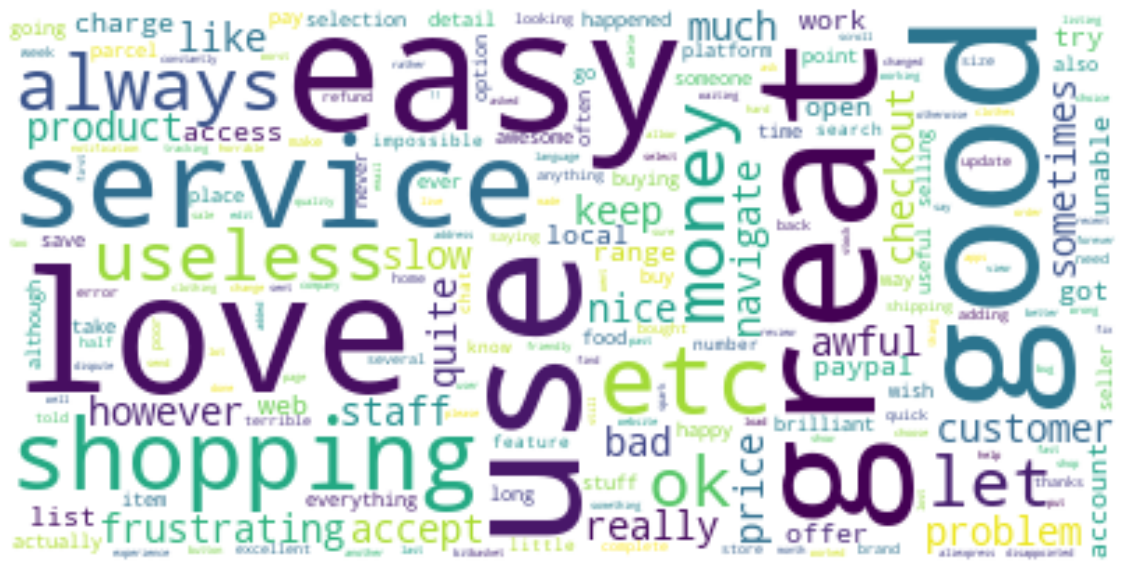

In [222]:
shein_features=get_specific_apps(shein)
cloud = WordCloud(max_font_size=60,background_color='white', colormap = 'viridis').generate_from_frequencies(shein_features)
plt.figure(figsize=(20,20))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [215]:
pos_tokens=[]
for index,row in pos_reviews.iterrows():
    pos_tokens.extend(row['tokens'])
    
shein_tokens=[]
for index,row in pos_reviews.iterrows():
    shein_tokens.extend(row['tokens'])

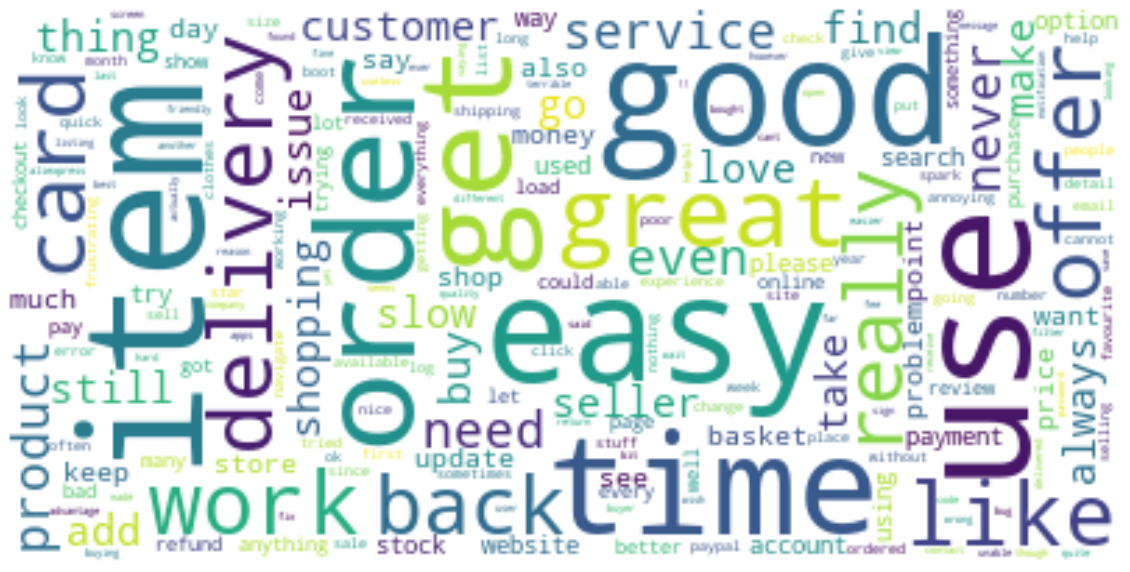

In [204]:
cloud = WordCloud(max_font_size=60,background_color='white', colormap = 'viridis').generate_from_frequencies(FreqDist(pos_tokens))
plt.figure(figsize=(20,20))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

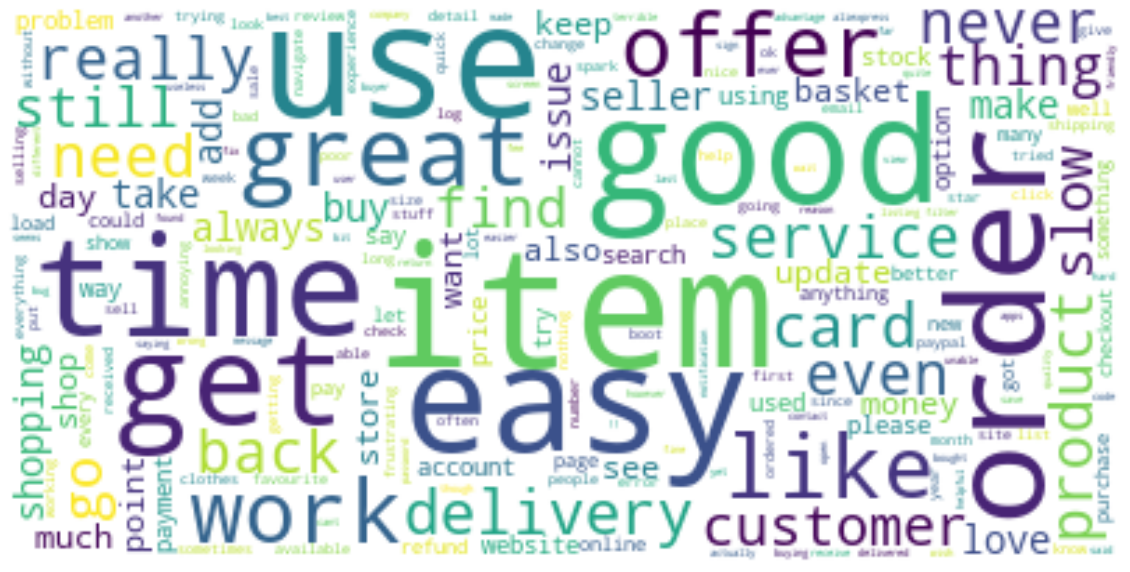

In [216]:
cloud = WordCloud(max_font_size=60,background_color='white', colormap = 'viridis').generate_from_frequencies(FreqDist(shein_tokens))
plt.figure(figsize=(20,20))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## VADER

In [109]:
# split reviews into setnences
# reviews_vader=shuffle(reviews_vader)
reviews_vader['sentences']=reviews_vader['content'].apply(lambda df:nltk.sent_tokenize(df))

In [110]:
# implement VADER sentiment analysis
for i in range(len(reviews_vader)):
    sid = SIA()
    sentiment = 0
    
    # loop the sentences
    for sen in reviews_vader.loc[i,'sentences']:
        ss = sid.polarity_scores(sen)
#         print('Sentence: ', sen, '   -> ', ss['compound'])
        sentiment += ss['compound']
    
    reviews_vader.loc[i,'compound']=sentiment
    
    if sentiment < -0.05:
        reviews_vader.loc[i,'sentiment']= 'negative'
        
    elif sentiment >0.05:
        reviews_vader.loc[i,'sentiment']= 'positive'
    else:
        reviews_vader.loc[i,'sentiment']= 'neutral'

<AxesSubplot:xlabel='sentiment'>

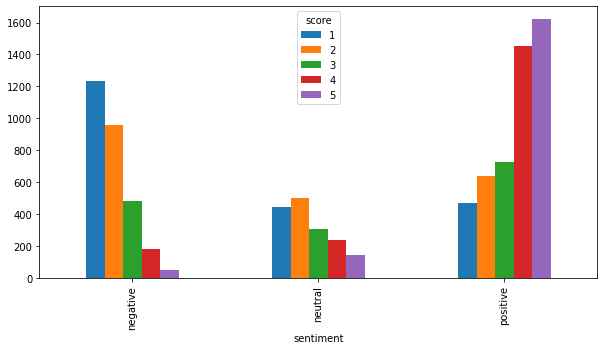

In [111]:
# visual sentiment
pd.crosstab(reviews_vader['sentiment'],reviews_vader['score']).plot.bar(figsize=(10,5))

In [146]:
# pd.DataFrame(reviews_vader.groupby(['title','polarity'])['content'].count())
# get df for sum up the number of different polarity for each app
app_po_count=pd.DataFrame({'count' : reviews_vader.groupby( [ 'title','sentiment'] ).size()}).reset_index()

# extract thumbsups comments
reviews_thumbsup=reviews_vader[reviews_vader['thumbsUpCount']>1]
app_po_count_thumbsup=pd.DataFrame({'count' : reviews_thumbsup.groupby( [ 'title','sentiment'] ).size()}).reset_index()

In [136]:
# calculate the proportion of each polarity for each app
def get_app_rate(df,polarity):
    total=df.groupby(['title'])['count'].sum().to_dict()
    rate={}
    
    for app in set(df['title'].to_list()):
        for index,row in app_po_count.iterrows():
            if app==row['title']:
                if row['sentiment']==polarity:
                    rate[app]=row['count']/total[app]
                    break
    return rate

In [137]:
app_posrate=get_app_rate(app_po_count,'positive')
app_negrate=get_app_rate(app_po_count,'negative')
app_neurate=get_app_rate(app_po_count,'neutral')

In [147]:
app_posrate_thumbsup=get_app_rate(app_po_count_thumbsup,'positive')
app_negrate_thumbsup=get_app_rate(app_po_count_thumbsup,'negative')
app_neurate_thumbsup=get_app_rate(app_po_count_thumbsup,'neutral')

#### Statistical analysis

In [116]:
reviews_vader_factorized=reviews_vader.copy()
reviews_vader_factorized=reviews_vader_factorized.drop(columns=['userName',  'thumbsUpCount', 'reviewCreatedVersion',
       'createYear', 'createMonth', 'title', 'appscore',  'sentences','compound'])
reviews_vader_factorized.sentiment=pd.factorize(reviews_vader_factorized.sentiment)[0]
reviews_vader_factorized['score']=reviews_vader_factorized['score'].astype(int)
reviews_vader_factorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9452 entries, 0 to 9451
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    9452 non-null   object
 1   score      9452 non-null   int32 
 2   sentiment  9452 non-null   int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 184.7+ KB


In [117]:
reviews_vader_factorized.groupby(['sentiment','score'])['content'].count()

sentiment  score
0          1        1233
           2         956
           3         480
           4         179
           5          48
1          1         446
           2         503
           3         307
           4         238
           5         146
2          1         472
           2         641
           3         729
           4        1453
           5        1621
Name: content, dtype: int64

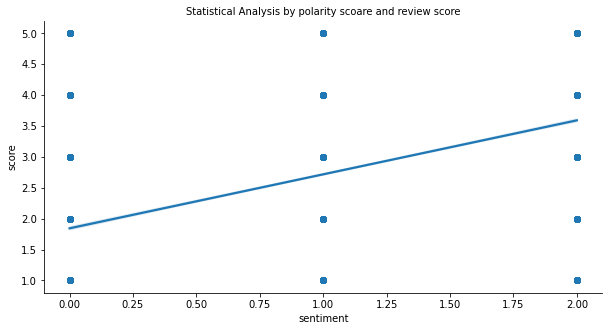

In [118]:
fig,ax=plt.subplots()
fig.set_size_inches(10,5)
plt.title('Statistical Analysis by polarity scoare and review score',fontsize=10)
sns.regplot(x='sentiment',y='score',data=reviews_vader_factorized)
sns.despine()

### so users tend to give lower score when they're neural

## LSTM


In [292]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

In [509]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 2000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 50
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(reviews_lstm['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9638 unique tokens.


In [510]:
X = tokenizer.texts_to_sequences(reviews_lstm['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(reviews_lstm['category']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (9455, 50)
Shape of label tensor: (9455, 3)


In [511]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6618, 50) (6618, 3)
(2837, 50) (2837, 3)


In [512]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mae'])

# history = model.fit(X_train, Y_train, epochs=10, batch_size=32,validation_data=(X_test, Y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
history = model.fit(X_train, Y_train, epochs=10, batch_size=64,validation_data=(X_test, Y_test))


Epoch 1/10
104/104 [==============================] - 20s 162ms/step - loss: 0.9137 - accuracy: 0.5987 - mae: 0.3657 - val_loss: 0.7873 - val_accuracy: 0.6824 - val_mae: 0.3185
Epoch 2/10
104/104 [==============================] - 18s 172ms/step - loss: 0.7163 - accuracy: 0.7121 - mae: 0.2764 - val_loss: 0.7142 - val_accuracy: 0.7201 - val_mae: 0.2763
Epoch 3/10
104/104 [==============================] - 17s 162ms/step - loss: 0.6445 - accuracy: 0.7421 - mae: 0.2442 - val_loss: 0.6981 - val_accuracy: 0.7272 - val_mae: 0.2557
Epoch 4/10
104/104 [==============================] - 17s 163ms/step - loss: 0.5808 - accuracy: 0.7688 - mae: 0.2223 - val_loss: 0.7093 - val_accuracy: 0.7166 - val_mae: 0.2451
Epoch 5/10
104/104 [==============================] - 18s 170ms/step - loss: 0.5486 - accuracy: 0.7838 - mae: 0.2095 - val_loss: 0.7477 - val_accuracy: 0.7155 - val_mae: 0.2328
Epoch 6/10
104/104 [==============================] - 16s 157ms/step - loss: 0.5108 - accuracy: 0.7962 - mae: 0.193

In [515]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

89/89 [==============================] - 2s 17ms/step - loss: 0.9147 - accuracy: 0.6898 - mae: 0.2337
Test set
  Loss: 0.915
  Accuracy: 0.690
